In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sys 
import os

# TODO: make more pythonic
# this line walks up file directory so rule-vetting is cwd
# Currently this breaks if chunk is run multiple times
os.chdir(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))))
print(os.getcwd())

/accounts/grad/wtorous/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


/accounts/grad/wtorous/rule-vetting


In [158]:
import rulevetting.api.viz as viz
from rulevetting.projects.csi_pecarn.dataset import Dataset

[autoreload of rulevetting.projects.csi_pecarn.dataset failed: Traceback (most recent call last):
  File "/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 376, in superreload
    module = reload(module)
  File "/usr/local/linux/anaconda3.7/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/local/linux/anaconda3.7/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call

In [159]:
dfs = Dataset().get_data(keep_na=False)

  0%|          | 0/12 [00:00<?, ?it/s]

read all the csvs...
 ['analysisvariables.csv', 'clinicalpresentationfield.csv', 'clinicalpresentationoutside.csv', 'clinicalpresentationsite.csv', 'demographics.csv', 'injuryclassification.csv', 'injurymechanism.csv', 'kappa.csv', 'medicalhistory.csv', 'radiologyoutside.csv', 'radiologyreview.csv', 'radiologysite.csv']


100%|██████████| 12/12 [00:01<00:00, 10.68it/s]
/accounts/grad/wtorous/.local/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


118 Raw Covariates Selected


/accounts/grad/wtorous/.local/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


split_data kwargs {'control_types': ['ran', 'moi', 'ems']}
['ran', 'moi', 'ems']


In [160]:
eda_df = dfs[0]

In [161]:
posthoc_columns = [col for col in eda_df.columns if 'posthoc' in col]
#eda_df.drop(posthoc_columns,axis=1,inplace=True)

In [141]:
print(list(eda_df.shape))

[1704, 98]


In [142]:
outcome_def = 'csi_injury'

In [143]:
eda_df.columns

Index(['AlteredMentalStatus', 'LOC', 'FocalNeuroFindings', 'PainNeck',
       'PosMidNeckTenderness', 'TenderNeck', 'Torticollis', 'SubInj_Head',
       'SubInj_Face', 'SubInj_Ext', 'SubInj_TorsoTrunk', 'Predisposed',
       'HighriskDiving', 'HighriskFall', 'HighriskHanging', 'HighriskHitByCar',
       'HighriskMVC', 'HighriskOtherMV', 'AxialLoadAnyDoc', 'axialloadtop',
       'Clotheslining', 'CervicalSpineImmobilization', 'GCSEye', 'MotorGCS',
       'VerbalGCS', 'TotalGCS', 'PtCompPainFace', 'PtCompPainHead',
       'PtTenderNeck', 'PtTenderFace', 'PtTenderHead',
       'posthoc_CervicalSpinePrecautionsCC',
       'posthoc_CervicalSpinePrecautionsRLB',
       'posthoc_CervicalSpinePrecautionsOther',
       'posthoc_IntervForCervicalStabSCollar',
       'posthoc_IntervForCervicalStabRCollar',
       'posthoc_IntervForCervicalStabBrace',
       'posthoc_IntervForCervicalStabTraction',
       'posthoc_IntervForCervicalStabSurgical',
       'posthoc_IntervForCervicalStabHalo',
       '

In [144]:
eda_df['GCS_na']

id       case_id  site  control_type
110001   110001   1     case            0.0
110021   110021   1     case            0.0
110019   110019   1     case            0.0
110002   110002   1     case            0.0
110011   110011   1     case            0.0
                                       ... 
1723134  1713099  17    ems             0.0
1723165  1713124  17    ems             0.0
1723141  1713104  17    ems             0.0
1723147  1713105  17    ems             0.0
1723135  1713119  17    ems             0.0
Name: GCS_na, Length: 1704, dtype: float64

In [126]:
# get list of columns with only two recorded outcomes
binary_columns = eda_df.columns[eda_df.nunique()==2]
binary_eda_data = eda_df.loc[:,binary_columns].copy() 

cont_columns = eda_df.columns[eda_df.nunique()!=2]
cont_eda_data = eda_df.loc[:,cont_columns].copy()
cont_eda_data.loc[:,outcome_def] = eda_df.loc[:,outcome_def].copy() #add binary outcome indicator back in

In [127]:
# outcome indicator is double counted
print(eda_df.shape)
print(binary_eda_data.shape)
print(cont_eda_data.shape)

(1704, 97)
(1704, 88)
(1704, 10)


In [128]:
print(cont_eda_data.head())

                                  GCSEye  MotorGCS  VerbalGCS  TotalGCS  \
id     case_id site control_type                                          
110001 110001  1    case             1.0       1.0        1.0       3.0   
110021 110021  1    case             4.0       6.0        5.0      15.0   
110019 110019  1    case             4.0       6.0        5.0      15.0   
110002 110002  1    case             4.0       6.0        5.0      15.0   
110011 110011  1    case             4.0       6.0        5.0      15.0   

                                               posthoc_Race posthoc_PayorType  \
id     case_id site control_type                                                
110001 110001  1    case                              White                CI   
110021 110021  1    case                              White                ND   
110019 110019  1    case                              White                CI   
110002 110002  1    case          Black or African American          

In [96]:
print(np.unique(eda_df.index.get_level_values('control_type')))

['case' 'ems' 'moi' 'ran']


In [ ]:
# Summary EDA

In [97]:
eda_df.describe()

,AlteredMentalStatus,LOC,FocalNeuroFindings,PainNeck,PosMidNeckTenderness,TenderNeck,Torticollis,SubInj_Head,SubInj_Face,SubInj_Ext,...,CTPerformed_outside_binary,MRIPerformed_outside_binary,posthoc_Xrays_site_binary,posthoc_CTPerformed_site_binary,posthoc_MRIPerformed_site_binary,NonVerbal,YoungAdult,HighRiskFallDownStairs,PainNeck_Robust,GCS_na
count,1704.000000,1704.000000,1704.000000,1704.000000,1704.000000,1704.000000,1704.000000,1704.000000,1704.000000,1704.000000,...,1704.00000,1704.000000,1704.000000,1704.000000,1704.000000,1704.000000,1704.000000,1704.000000,1704.000000,1704.000000
mean,0.178404,0.365610,0.115023,0.329225,0.284038,0.370892,0.054577,0.120892,0.051643,0.090376,...,0.02054,0.000587,0.920775,0.327465,0.122066,0.191315,0.457160,0.023474,0.343310,0.059859
std,0.382965,0.481742,0.319144,0.470070,0.451087,0.483185,0.227220,0.326097,0.221371,0.286803,...,0.14188,0.024225,0.270169,0.469426,0.327458,0.393452,0.498308,0.151448,0.474953,0.237295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [153]:
binary_imputed_data = binary_eda_data.fillna(0)
print(binary_eda_data.shape, binary_imputed_data.shape)
binary_corrs = binary_imputed_data.corr(method='spearman')
cont_corrs = cont_eda_data.corr(method='spearman')

print(binary_imputed_data.columns)

(1704, 88) (1704, 88)
Index(['AlteredMentalStatus', 'LOC', 'FocalNeuroFindings', 'PainNeck',
       'PosMidNeckTenderness', 'TenderNeck', 'Torticollis', 'SubInj_Head',
       'SubInj_Face', 'SubInj_Ext', 'SubInj_TorsoTrunk', 'Predisposed',
       'HighriskDiving', 'HighriskFall', 'HighriskHanging', 'HighriskHitByCar',
       'HighriskMVC', 'HighriskOtherMV', 'AxialLoadAnyDoc', 'axialloadtop',
       'Clotheslining', 'CervicalSpineImmobilization', 'PtCompPainFace',
       'PtCompPainHead', 'PtTenderNeck', 'PtTenderFace', 'PtTenderHead',
       'posthoc_CervicalSpinePrecautionsCC',
       'posthoc_CervicalSpinePrecautionsRLB',
       'posthoc_CervicalSpinePrecautionsOther',
       'posthoc_IntervForCervicalStabSCollar',
       'posthoc_IntervForCervicalStabRCollar',
       'posthoc_IntervForCervicalStabBrace',
       'posthoc_IntervForCervicalStabTraction',
       'posthoc_IntervForCervicalStabSurgical',
       'posthoc_IntervForCervicalStabHalo',
       'posthoc_IntervForCervicalStabInt

Text(0.5, 0.98, 'Spearman Correlation of Binary Covariates with Mean Imputation')

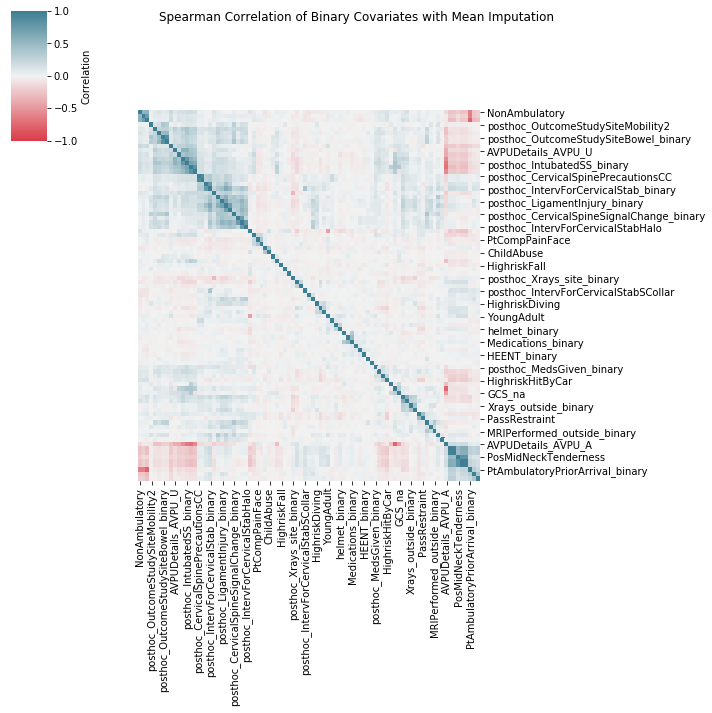

In [99]:
binary_corrmap = sns.clustermap(binary_corrs, cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
binary_corrmap.ax_row_dendrogram.set_visible(False)
binary_corrmap.ax_col_dendrogram.set_visible(False)
binary_corrmap.fig.suptitle("Spearman Correlation of Binary Covariates with Mean Imputation")

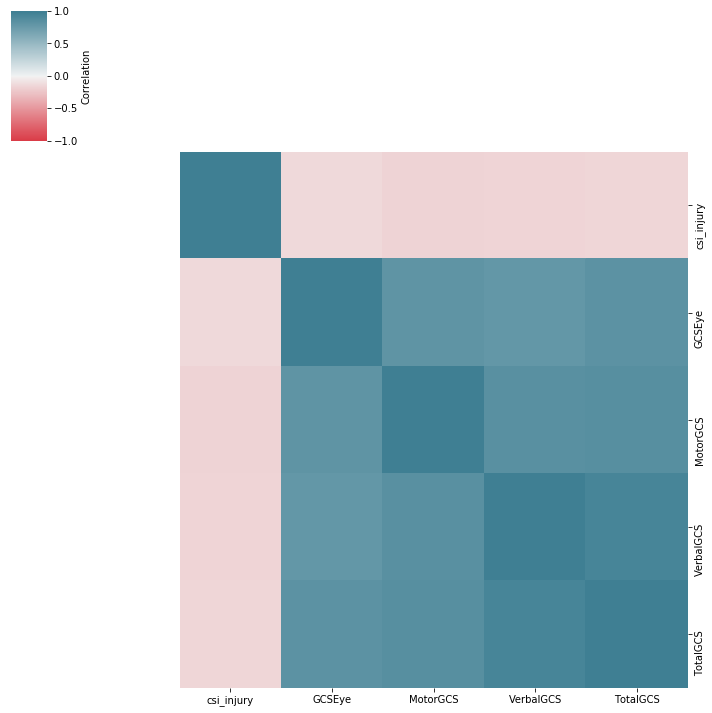

In [145]:
cont_corrmap = sns.clustermap(cont_corrs, cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
cont_corrmap.ax_row_dendrogram.set_visible(False)
cont_corrmap.ax_col_dendrogram.set_visible(False)

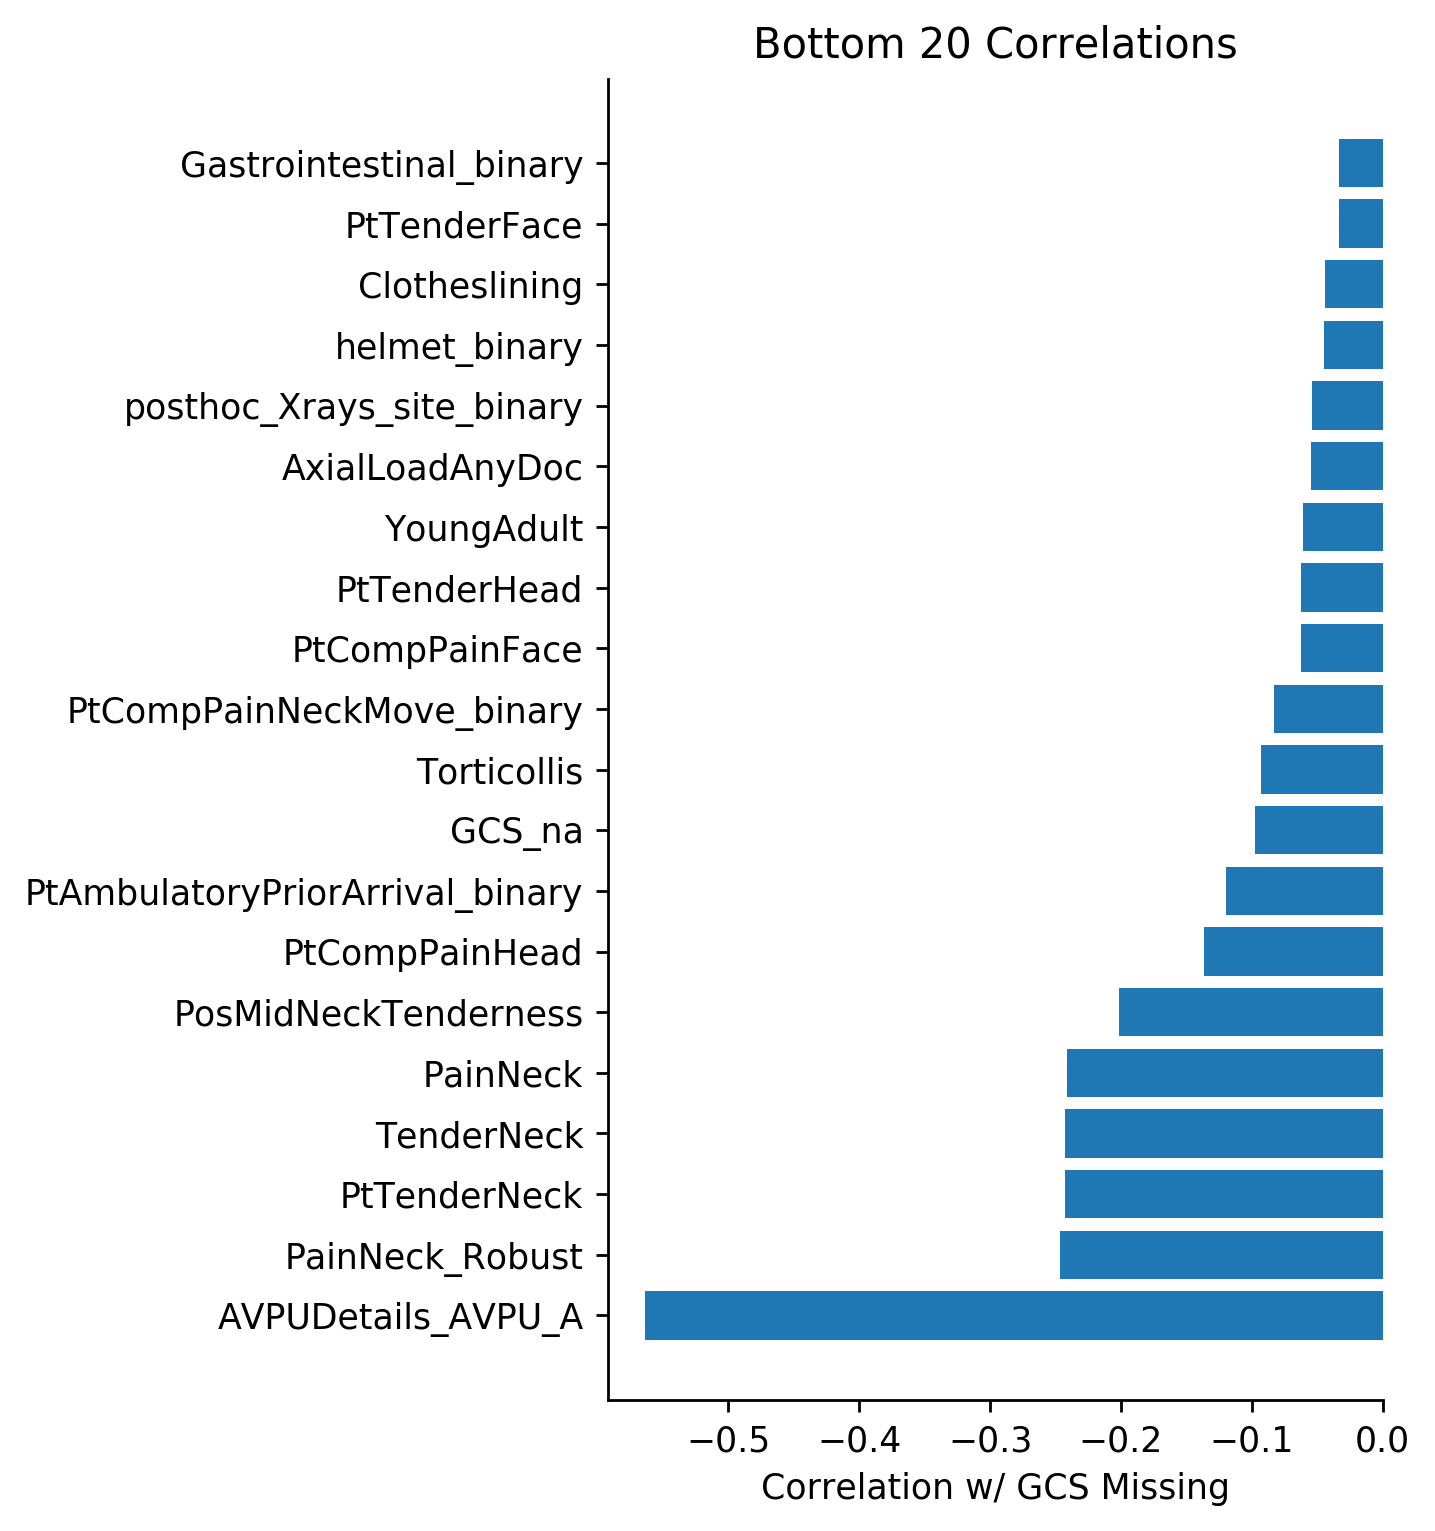

In [146]:
plt.figure(dpi=250, figsize=(4, 7))
#vals = binary_corrs[outcome_def]
vals = binary_corrs['GCSnot15']
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs[:20], vals[args][:20])
plt.xlabel('Correlation w/ GCS Missing')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title("Bottom 20 Correlations")
plt.show()

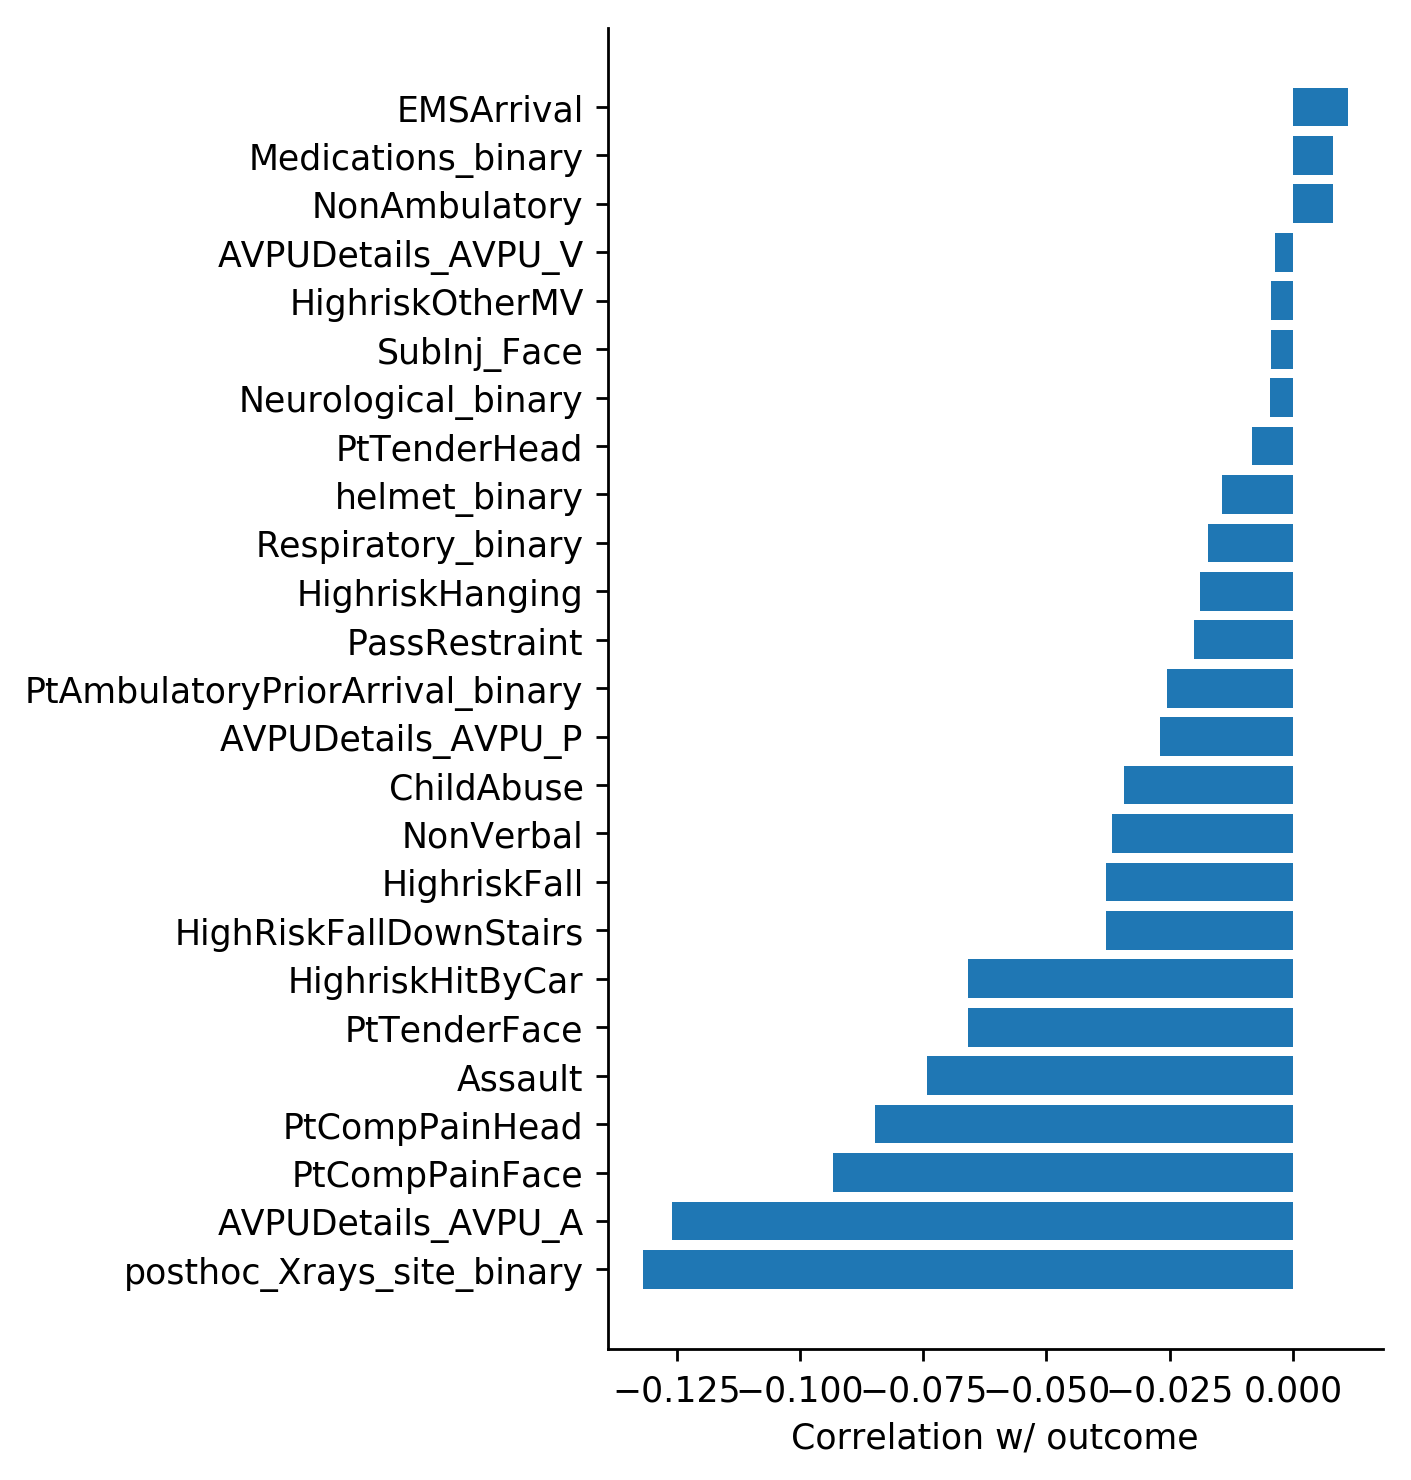

In [147]:
plt.figure(dpi=250, figsize=(4, 7))
vals = binary_corrs['csi_injury']
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs[:25], vals[args][:25])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [154]:
binary_imputed_data.columns

Index(['AlteredMentalStatus', 'LOC', 'FocalNeuroFindings', 'PainNeck',
       'PosMidNeckTenderness', 'TenderNeck', 'Torticollis', 'SubInj_Head',
       'SubInj_Face', 'SubInj_Ext', 'SubInj_TorsoTrunk', 'Predisposed',
       'HighriskDiving', 'HighriskFall', 'HighriskHanging', 'HighriskHitByCar',
       'HighriskMVC', 'HighriskOtherMV', 'AxialLoadAnyDoc', 'axialloadtop',
       'Clotheslining', 'CervicalSpineImmobilization', 'PtCompPainFace',
       'PtCompPainHead', 'PtTenderNeck', 'PtTenderFace', 'PtTenderHead',
       'posthoc_CervicalSpinePrecautionsCC',
       'posthoc_CervicalSpinePrecautionsRLB',
       'posthoc_CervicalSpinePrecautionsOther',
       'posthoc_IntervForCervicalStabSCollar',
       'posthoc_IntervForCervicalStabRCollar',
       'posthoc_IntervForCervicalStabBrace',
       'posthoc_IntervForCervicalStabTraction',
       'posthoc_IntervForCervicalStabSurgical',
       'posthoc_IntervForCervicalStabHalo',
       'posthoc_IntervForCervicalStabIntFix',
       'posthoc_

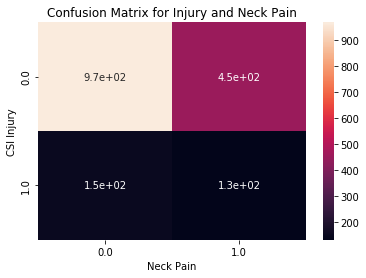

In [157]:
confusion_matrix = pd.crosstab(binary_imputed_data['csi_injury'], binary_imputed_data['PtCompPainNeck'], rownames=['CSI Injury'], colnames=['Neck Pain'])

sns.heatmap(confusion_matrix, annot=True)
plt.title("Confusion Matrix for Injury and Neck Pain")
plt.show()


In [149]:
print(eda_df['TotalGCS'])

id       case_id  site  control_type
110001   110001   1     case             3.0
110021   110021   1     case            15.0
110019   110019   1     case            15.0
110002   110002   1     case            15.0
110011   110011   1     case            15.0
                                        ... 
1723134  1713099  17    ems             15.0
1723165  1713124  17    ems             15.0
1723141  1713104  17    ems             15.0
1723147  1713105  17    ems             15.0
1723135  1713119  17    ems             15.0
Name: TotalGCS, Length: 1704, dtype: float64


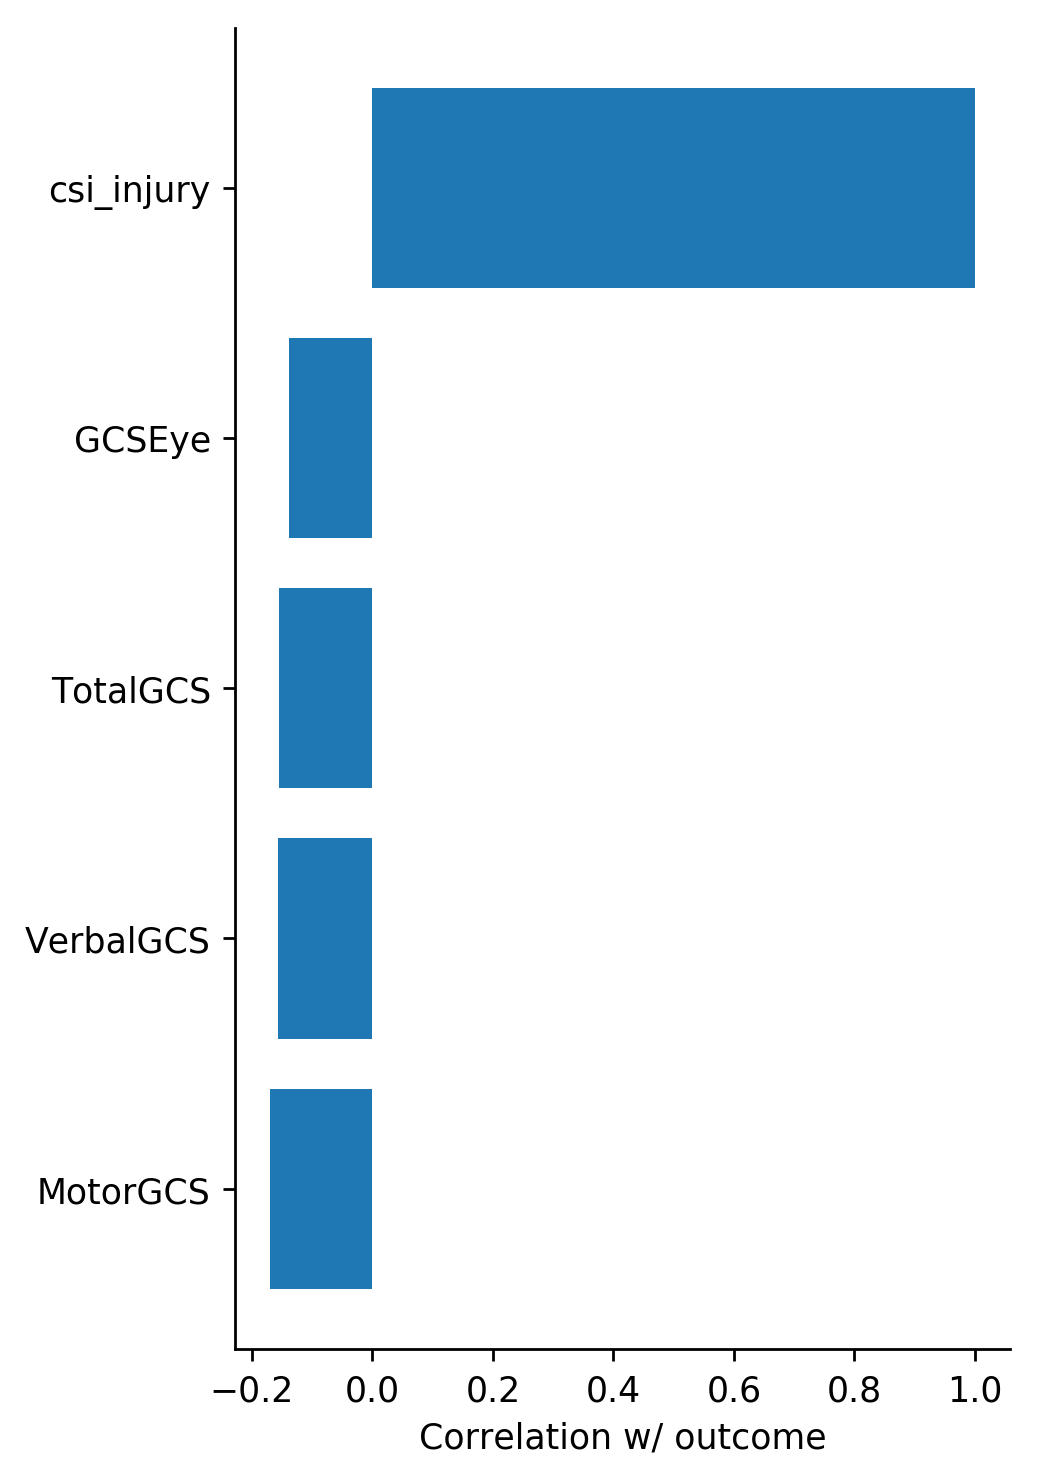

In [150]:
plt.figure(dpi=250, figsize=(4, 7))
vals = cont_corrs[outcome_def]
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs, vals[args])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(binary_corrs['GCS_NA_total'].sort_values())

In [ ]:
# EDA of Missingness

In [ ]:
# get percent missing by column
pd.set_option("display.max_rows", None, "display.max_columns", None)
print("25 Covariates with Highest Percent Missingness\n")
print("All Covariates:")
missing_frac = (eda_df.isna().sum() / eda_df.shape[0]) * 100
print(missing_frac.sort_values(ascending=False)[:])

In [ ]:
complete_covar = missing_frac[missing_frac==0.]
print("Covar. with no missing data:",len(complete_covar))

missing_columns = missing_frac[missing_frac!=0]
print("Covar. with some missing data:",len(missing_columns))

In [ ]:
binary_missing_bools = eda_df[missing_columns.index].isna()
binary_missing_corrs = binary_missing_bools.corr(method='spearman')

In [ ]:
corrmap = sns.clustermap(binary_missing_corrs, cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
corrmap.ax_row_dendrogram.set_visible(False)
corrmap.ax_col_dendrogram.set_visible(False)
plt.title("Correlation of Missigness by Covariate")

In [ ]:
print(max(binary_missing_corrs))

In [ ]:
print(sorted(binary_missing_corrs.iloc[:,3]))

In [ ]:
# EDA of Demographic Data

In [ ]:
eda_demographic_df = pd.read_csv("data/csi_pecarn/raw/demographics.csv").set_index(["studysubjectid"])
print(eda_demographic_df.columns)

In [ ]:
gender_df = eda_demographic_df.groupby('site')['Gender'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Gender Variable Across Study Sites')
gender_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()

In [ ]:
race_df = eda_demographic_df.groupby('site')['Race'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Race Variable Across Study Sites')
race_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()

In [ ]:
ethnicity_df = eda_demographic_df.groupby('site')['Ethnicity'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Ethnicity Variable Across Study Sites')
ethnicity_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()

In [ ]:
payor_df = eda_demographic_df.groupby('site')['PayorType'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Payor Type Across Study Sites')
payor_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()

In [ ]:
age_df = eda_demographic_df[['site','AgeInYears']]


bins = [0, 2, 5, 10, 13, np.inf]
names = ['<2', '2-5', '5-10', '10-13', '13+']

age_df.loc[:,['AgeBin']] = pd.cut(age_df.loc[:,'AgeInYears'], bins, labels=names)

age_range_df = age_df.groupby('site')['AgeBin'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Age Range Across Study Sites')
age_range_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()
